In [1]:
from tqdm import tqdm
import gc
import pickle
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
train_df = pl.read_parquet(
    "data/raw/train.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [ ]:
test_df = pl.read_parquet(
    "data/raw/test.parquet",
    use_pyarrow=True,   
    low_memory=True
).lazy()

In [4]:
print(train_df.columns)

['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X13

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_80077/293337480.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(train_df.columns)


In [5]:
# drop timestamp since test data does not have timestamp
train_df = train_df.drop("timestamp")

In [6]:
# Check for nas in train or test
temp = train_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col

[]

In [7]:
temp = test_df.null_count().collect()
has_null_col = [col for col in temp.columns if temp[col].sum() != 0]
has_null_col
# no nas issue in train and test

[]

In [8]:
# check all possible datatypes
print(set(train_df.dtypes))

{Float64}


/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_80077/1737341288.py:2: PerformanceWarning: Determining the data types of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().dtypes()` to get the data types without this warning.
  print(set(train_df.dtypes))


In [9]:
# check for possible constant columns
constant_columns = []
for col in train_df.columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        constant_columns.append(col)
print(constant_columns)

/var/folders/5b/jn4p_4vx7j9gx2jdrmbjlxnr0000gn/T/ipykernel_80077/2295361549.py:3: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col in train_df.columns:


['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


In [10]:
# check if same issue might also appear in test
actual_constant_columns = []
for col in constant_columns:
    if train_df.select(col).min().collect()[0, 0] == train_df.select(col).max().collect()[0, 0]:
        actual_constant_columns.append(col)
print(set(constant_columns) - set(actual_constant_columns)) # all are constant => can remove?

set()


In [11]:
train_df = train_df.drop(actual_constant_columns)

In [12]:
# # get columns pair that is perfectly (or very highly) correlated
# correlated_pair = []
# col_names = train_df.collect_schema().names()
# for i in tqdm(range(len(col_names) - 1)):
#     col1 = col_names[i]
#     if col1 not in constant_columns:
#         for j in range(i + 1, len(col_names)):
#             col2 = col_names[j]
#             if col2 not in constant_columns:
#                 x = train_df.select(col1).collect()[col1].to_numpy()
#                 y = train_df.select(col2).collect()[col2].to_numpy()
#                 if np.corrcoef(x, y)[0][1] == 1:
#                     correlated_pair.append(f"{col1}-{col2}")
# print(correlated_pair)
# print(len(correlated_pair))

In [13]:
correlated_pair = ['X62-X104', 'X62-X146', 'X74-X116', 'X74-X158', 'X86-X128', 'X86-X170', 'X92-X134', 'X92-X176', 'X98-X140', 'X98-X182', 'X104-X146', 'X116-X158', 'X128-X170', 'X134-X176', 'X140-X182', 'X315-X357', 'X315-X399', 'X321-X363', 'X321-X405', 'X327-X369', 'X327-X411', 'X333-X375', 'X333-X417', 'X339-X381', 'X339-X423', 'X357-X399', 'X363-X405', 'X369-X411', 'X375-X417', 'X381-X423']
actual_correlated_pair = []
for cp in correlated_pair:
    col1, col2 = cp.split("-")
    x = test_df.select(col1).collect()[col1].to_numpy()
    y = test_df.select(col2).collect()[col2].to_numpy()
    if np.corrcoef(x, y)[0][1] == 1:
        actual_correlated_pair.append(f"{col1}-{col2}")
set(correlated_pair) - set(actual_correlated_pair)

{'X140-X182', 'X321-X363', 'X321-X405', 'X363-X405', 'X98-X140', 'X98-X182'}

In [14]:
# Group into correlated group
correlated_group = []
for cp in actual_correlated_pair:
    cp_lst = cp.split("-")
    added = False
    for inx, cg in enumerate(correlated_group):
        for var in cp_lst:
            if var in cg:
                correlated_group[inx].extend(cp_lst)
                correlated_group[inx] = list(set(correlated_group[inx]))
                added = True
                break
        if added:
            break
    if not added:
        correlated_group.append(cp_lst)
correlated_group
# 8 groups of perfectly correlated features, try to check if same things happen in test

[['X146', 'X62', 'X104'],
 ['X116', 'X74', 'X158'],
 ['X128', 'X86', 'X170'],
 ['X92', 'X176', 'X134'],
 ['X357', 'X315', 'X399'],
 ['X369', 'X327', 'X411'],
 ['X333', 'X417', 'X375'],
 ['X381', 'X339', 'X423']]

In [15]:
removed_col = []
for cg in correlated_group:
    removed_col.extend(cg[1:])
train_df = train_df.drop(removed_col)

In [16]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 50000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.drop("label").slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


<Axes: >

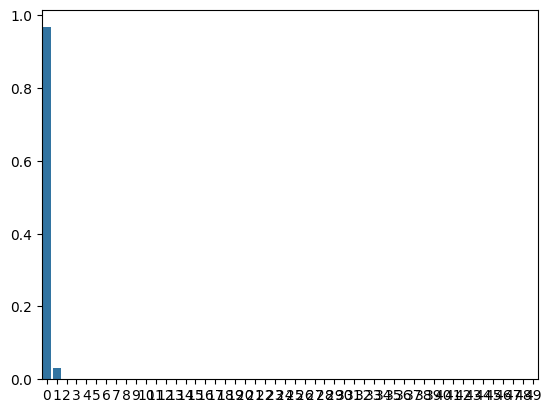

In [17]:
sns.barplot(inc_PCA.explained_variance_ratio_)

In [18]:
pc1_component = pd.DataFrame(
    {
        "var": inc_PCA.feature_names_in_,
        "pc1_contribution": inc_PCA.components_[0]
    }
)

pc1_component = pc1_component.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution
0,volume,8.164894e-01
1,sell_qty,4.101512e-01
2,buy_qty,4.063382e-01
3,bid_qty,-1.431198e-03
4,ask_qty,-1.376846e-03
...,...,...
847,X263,2.643868e-07
848,X234,2.461852e-07
849,X791,2.011902e-07
850,X347,1.814764e-08


In [19]:
# Use the top 50 features
print(pc1_component.iloc[:50, ]["var"].tolist())

['volume', 'sell_qty', 'buy_qty', 'bid_qty', 'ask_qty', 'X596', 'X594', 'X877', 'X879', 'X597', 'X880', 'X595', 'X878', 'X544', 'X551', 'X558', 'X873', 'X117', 'X565', 'X882', 'X153', 'X123', 'X111', 'X502', 'X495', 'X75', 'X881', 'X509', 'X394', 'X141', 'X147', 'X388', 'X87', 'X99', 'X352', 'X105', 'X876', 'X346', 'X572', 'X451', 'X81', 'X69', 'X452', 'X516', 'X177', 'X480', 'X456', 'X135', 'X883', 'X406']


In [20]:
# Also need to check correlation with target variable
var_label_correlation = []
for i in tqdm(range(pc1_component.shape[0])):
    var = pc1_component.loc[i, "var"]
    var_label_correlation.append(train_df.select(pl.corr(var, "label")).collect().item())
pc1_component["var_label_correlation"] = var_label_correlation
pc1_component

100%|██████████| 852/852 [00:00<00:00, 2131.98it/s]


,var,pc1_contribution,var_label_correlation
0,volume,8.164894e-01,0.008809
1,sell_qty,4.101512e-01,0.011166
2,buy_qty,4.063382e-01,0.005618
3,bid_qty,-1.431198e-03,-0.013220
4,ask_qty,-1.376846e-03,-0.015762
...,...,...,...
847,X263,2.643868e-07,0.012352
848,X234,2.461852e-07,0.004803
849,X791,2.011902e-07,0.001805
850,X347,1.814764e-08,-0.010130


In [21]:
pc1_component.sort_values("var_label_correlation", ascending=False, key = lambda x: abs(x))

,var,pc1_contribution,var_label_correlation
430,X21,0.000022,0.069401
416,X20,0.000024,0.067667
219,X28,0.000049,0.064092
496,X863,-0.000017,0.064057
202,X29,0.000052,0.062339
...,...,...,...
447,X795,-0.000021,-0.000185
265,X128,-0.000042,0.000120
121,X475,0.000079,-0.000063
13,X544,-0.000322,-0.000042


In [22]:
pc1_component["pc1_contribution_rnk"] = pc1_component["pc1_contribution"].abs().rank(method = "min", ascending=False)
pc1_component["var_label_correlation_rnk"] = pc1_component["var_label_correlation"].abs().rank(method = "min", ascending=False)
pc1_component["average_rnk"] = (pc1_component["pc1_contribution_rnk"] + pc1_component["var_label_correlation_rnk"]) / 2
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,8.164894e-01,0.008809,1.0,603.0,302.0
1,sell_qty,4.101512e-01,0.011166,2.0,538.0,270.0
2,buy_qty,4.063382e-01,0.005618,3.0,697.0,350.0
3,bid_qty,-1.431198e-03,-0.013220,4.0,478.0,241.0
4,ask_qty,-1.376846e-03,-0.015762,5.0,402.0,203.5
...,...,...,...,...,...,...
847,X263,2.643868e-07,0.012352,848.0,502.0,675.0
848,X234,2.461852e-07,0.004803,849.0,722.0,785.5
849,X791,2.011902e-07,0.001805,850.0,804.0,827.0
850,X347,1.814764e-08,-0.010130,851.0,571.0,711.0


In [23]:
popular_var = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]
pc1_component[pc1_component["var"].isin(popular_var)]

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,volume,0.816489,0.008809,1.0,603.0,302.0
1,sell_qty,0.410151,0.011166,2.0,538.0,270.0
2,buy_qty,0.406338,0.005618,3.0,697.0,350.0
3,bid_qty,-0.001431,-0.013220,4.0,478.0,241.0
4,ask_qty,-0.001377,-0.015762,5.0,402.0,203.5
133,X345,-0.000076,-0.011439,134.0,527.0,330.5
165,X137,-0.000060,-0.044290,166.0,51.0,108.5
186,X862,0.000057,0.040828,187.0,65.0,126.0
329,X344,0.000032,-0.009061,330.0,597.0,463.5
354,X855,0.000029,0.037702,355.0,88.0,221.5


In [24]:
pc1_component = pc1_component.sort_values("average_rnk").reset_index().drop("index", axis = 1)
pc1_component

,var,pc1_contribution,var_label_correlation,pc1_contribution_rnk,var_label_correlation_rnk,average_rnk
0,X473,1.494225e-04,0.040200,54.0,73.0,63.5
1,X451,1.803425e-04,0.035329,40.0,106.0,73.0
2,X111,-2.361445e-04,0.033087,23.0,126.0,74.5
3,X153,-2.469401e-04,0.032990,21.0,128.0,74.5
4,X205,1.427800e-04,0.036817,59.0,97.0,78.0
...,...,...,...,...,...,...
847,X101,-1.208360e-06,-0.001161,827.0,817.0,822.0
848,X78,1.253916e-06,0.000942,826.0,823.0,824.5
849,X791,2.011902e-07,0.001805,850.0,804.0,827.0
850,X790,-6.532309e-07,-0.001051,840.0,820.0,830.0


In [ ]:
best_pc1_contribution = pc1_component[pc1_component["pc1_contribution_rnk"] <= 100]["var"].tolist()
with open("features/best_pc1_contribution.pkl", "wb") as f:
    pickle.dump(best_pc1_contribution, f)

In [ ]:
best_label_correlation = pc1_component[pc1_component["var_label_correlation_rnk"] <= 100]["var"].tolist()
with open("features/best_label_correlation.pkl", "wb") as f:
    pickle.dump(best_label_correlation, f)

In [ ]:
best_overall = (pc1_component.loc[:50, "var"].to_list())
best_overall.extend(["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"])
with open("features/best_overall.pkl", "wb") as f:
    pickle.dump(best_overall, f)

In [31]:
# Incremental PCA
inc_PCA = IncrementalPCA(n_components = 50)

# fitting a batch every turn
n_rows = train_df.select("bid_qty").count().collect()[0, 0]
batch_size = 50000
for i in tqdm(range(0, n_rows, batch_size)):
    length = min(n_rows - i, batch_size)
    train_df_batch = train_df.select(best_label_correlation).slice(offset = i, length = length).collect()
    inc_PCA.partial_fit(train_df_batch)

100%|██████████| 11/11 [00:02<00:00,  4.60it/s]


<Axes: >

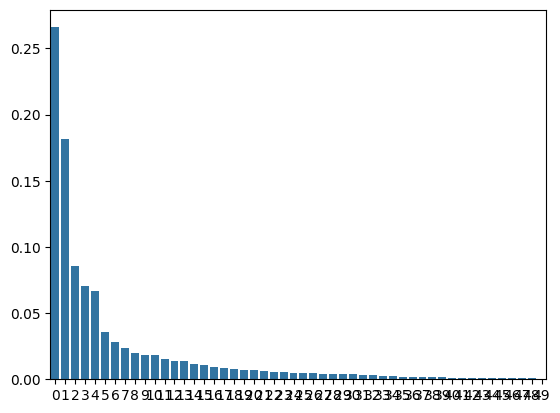

In [32]:
sns.barplot(inc_PCA.explained_variance_ratio_)

<Axes: >

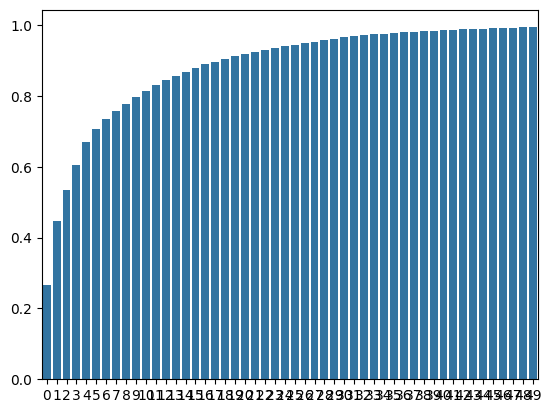

In [33]:
sns.barplot(np.cumsum(inc_PCA.explained_variance_ratio_))

In [63]:
# count appearance in top k factors in top 5 components
top_contribution = {}

for i in range(4):
    temp = pd.DataFrame(
        {
            "var": inc_PCA.feature_names_in_,
            "pc1_contribution": inc_PCA.components_[i]
        }
    )
    temp_lst = temp.sort_values("pc1_contribution", ascending=False, key = lambda x: abs(x)).iloc[:10, ]["var"].tolist()
    for var in temp_lst:
        top_contribution[var] = top_contribution.get(var, 0) + inc_PCA.explained_variance_ratio_[i]
top_contribution = pd.DataFrame(
    {
        "var": list(top_contribution.keys()),
        "contribution": list(top_contribution.values())
    }
).sort_values("contribution", ascending=False).reset_index().drop("index", axis = 1)
top_contribution.loc[:20,]

,var,contribution
0,X217,0.447664
1,X868,0.447664
2,X473,0.422322
3,X466,0.336577
4,X218,0.266039
5,X225,0.266039
6,X137,0.266039
7,X89,0.266039
8,X169,0.266039
9,X224,0.266039
